# "Starting with Medical Imaging"
> "Starter notebook that looks at some high level considerations when modeling and evaluating models for medical diagnosis"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [medical_imaging, dicom, model_evaluation, PPV, NPV, Specificity, Sensitivity]
- image: images/dicom_wf.PNG

> Note: This is the 2nd notebook in this series

## Goal:

The goals of this starter notebook are to:
- use DICOMs as the image input
- high level overview of what considerations need to be taken and what the results mean when creating a model that predicts medical conditions


The dataset used is conveniently provided by `fastai` - SIIM-ACR Pneumothorax Segmentation dataset and contains 250 Dicom images (175 No Pneumothorax and 75 Pneumothorax)

Considerations:
 - patient overlap
 - sampling
 - evaluting AI models for medical use

> Note: This notebook is based on [this](https://github.com/fastai/fastai/blob/master/nbs/61_tutorial.medical_imaging.ipynb)  fastai notebook. For more information about DICOMs and medical imaging you can click [here](https://github.com/asvcode/medical_imaging)

In [1]:
#load dependancies
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom
import seaborn as sns
matplotlib.rcParams['image.cmap'] = 'bone'

### Load the Data

In [2]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)
items = get_dicom_files(pneumothorax_source, recurse=True, folders='sm')
df = pd.read_csv(pneumothorax_source/f"labels_sm.csv")

In [3]:
items

(#26) [Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000000 - Copy.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000006 - Copy.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000011.dcm')...]

> Note: The SIIM_SMALL dataset has no duplicate patient IDs, has an equal number of males and females so I am using a custom even smaller dataset to show the functionality of `DicomSplit` and `DataSplit` below

### Viewing the Data

#### View Dicom

The `show` function is specifically tailored to display `.dcm` formats. By customizing the `show` function we have now view patient information with each image

In [4]:
@patch
@delegates(show_image)
def show_dinfo(self:DcmDataset, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    """show function that prints patient attributes from DICOM head"""
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    print(f'Patient Age: {self.PatientAge}')
    print(f'Patient Sex: {self.PatientSex}')
    print(f'Body Part Examined: {self.BodyPartExamined}')
    print(f'Rows: {self.Rows} Columns: {self.Columns}')
    show_image(px, cmap=cmap, **kwargs)

Patient Age: 31
Patient Sex: M
Body Part Examined: CHEST
Rows: 1024 Columns: 1024


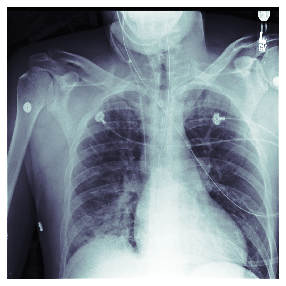

In [5]:
patient = 7
sample = dcmread(items[patient])
sample.show_dinfo()

#### Create a Dataframe of all the `tags` in the header section

> Tip: The head section of a `DICOM` images contains alot of useful information (known as `tags`) and `fastai` provides a conveninent way by using the `from_dicoms` function of getting that information and placing it into a `DataFrame`.  However we do not need to have all the information ported to a `Dataframe`

For example we can create a `DataFrame` of all the `tags` in the header section.  In this case there are 42 columns and in most cases we do not need all this information

In [9]:
full_dataframe = pd.DataFrame.from_dicoms(items)
full_dataframe[:1]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,19010101,000000.00,,CR,WSD,,view: PA,...,01,ISO_10918_1,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000000 - Copy.dcm,1,0.168,0,254,160.398039,53.854885,0.087029


We can create a custom dataframe that takes into consideration the information we want, for example:
- filename
- age
- sex
- row size
- column size

In [10]:
#updating to accomodate 
def _dcm2dict2(fn, **kwargs): 
        t = fn.dcmread()
        return fn, t.PatientID, t.PatientAge, t.PatientSex, t.Rows, t.Columns

@delegates(parallel)
def _from_dicoms2(cls, fns, n_workers=0, **kwargs):
    return pd.DataFrame(parallel(_dcm2dict2, fns, n_workers=n_workers, **kwargs))
pd.DataFrame.from_dicoms2 = classmethod(_from_dicoms2)

In [11]:
test_df = pd.DataFrame.from_dicoms2(items)
test_df.columns=['file', 'PatientID', 'Age', 'Sex', 'Rows', 'Cols']
test_df.to_csv('test_df.csv')
test_df.head()

,file,PatientID,Age,Sex,Rows,Cols
0,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000000 - Copy.dcm,16d7f894-55d7-4d95-8957-d18987f0e981,62,M,1024,1024
1,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000000.dcm,16d7f894-55d7-4d95-8957-d18987f0e981,62,M,1024,1024
2,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000002.dcm,850ddeb3-73ac-45e0-96bf-7d275bc83782,52,F,1024,1024
3,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000005.dcm,e0fd6161-2b8d-4757-96bc-6cf620a993d5,65,F,1024,1024
4,C:\Users\avird\.fastai\data\siim_small\sm\No Pneumothorax\000006 - Copy.dcm,99171908-3665-48e8-82c8-66d0098ce209,52,F,1024,1024


### EDA

We can do some exploratory data analysis and see that this custom dataset has duplicate patient IDs

In [8]:
#Plot 3 comparisons
def plot_comparison(df, feature, feature1, feature2):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    s3 = sns.countplot(df[feature2], ax=ax3)
    s3.set_title(feature2)
    plt.show()

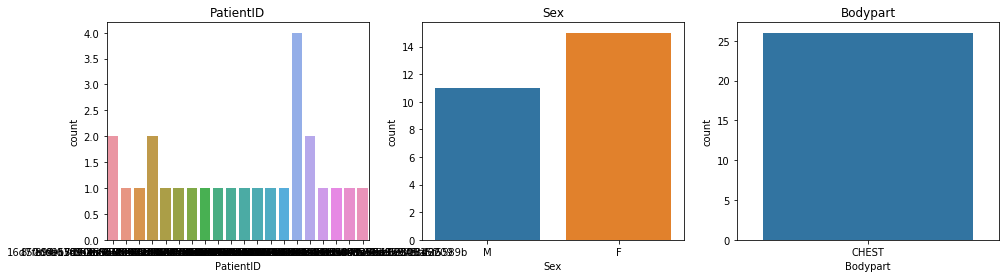

In [9]:
plot_comparison(test_df, 'PatientID', 'Sex', 'Bodypart')

**Age comparison**

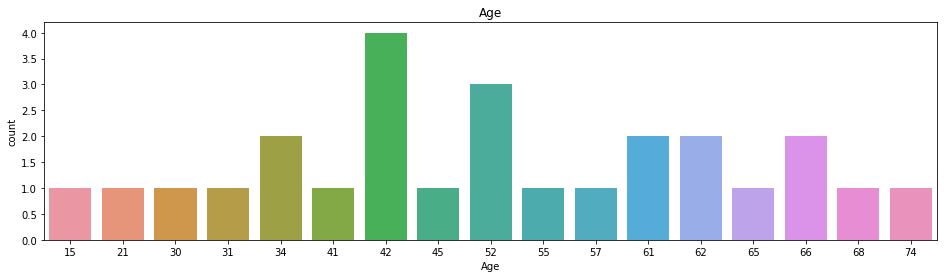

In [10]:
def age_comparison(df, feature):
    "Plot hisogram of age range in dataset"
    fig, (ax1) = plt.subplots(1,1, figsize = (16, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    plt.show()
    
age_comparison(test_df, 'Age')

### Modelling

Some considerations when modelling the data:
 - is there patient overlap between train and validation sets
 - sampling - how many negative and postive cases are represented in the train/val split
 - augmentations - consideration of what augmentations are used and why in some cases may not be useful

#### Patient Overlap

It is important to know if there is going to be any patient overlap when creating the train and validation sets as this may lead to an overly optimistic result when evaluating against a test set.  The great thing about `DICOMs` is that we can check to see if there are any duplicate `patientID`s in the test and valid sets when we split our data

##### DicomSplit

`DicomSplit` is a custom function that uses the default `fastai` splitting function that splits the data into train and validation sets based on `valid_pct` value but now also checks to see if identical patient IDs exist in both the train and validation sets.

In [13]:
def DicomSplit(valid_pct=0.2, seed=None, **kwargs):
    "Splits `items` between train/val with `valid_pct`"
    "and checks if identical patient IDs exist in both the train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        trn = rand_idx[cut:]; trn_p = o[rand_idx[cut:]]
        val = rand_idx[:cut]; val_p = o[rand_idx[:cut]]
        
        for i, im in enumerate(trn_p):
            trn = im.dcmread()
            patient_ID = trn.PatientID
            train_list.append(patient_ID)
        for j, jm in enumerate(val_p):
            val = jm.dcmread()
            vpatient_ID = val.PatientID
            valid_list.append(vpatient_ID) 
        print(set(train_list) & set(valid_list))
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

> Tip: There are a number of ways of setting the seed to ensure reproducible results. The easiest way in `fastai` is to use `set_seed` or you could incorporate it within a function

In [14]:
set_seed(7)

trn,val = DicomSplit(valid_pct=0.2)(items)
trn, val

{'6224213b-a185-4821-8490-c9cba260a959'}


((#21) [2,13,9,12,11,24,8,14,16,6...], (#5) [19,18,3,23,17])

The custom test dataset only has 26 images (small number of images to show how `DicomSplit` works) which is split into a `test` set of 21 and a `valid` set of 5 using `valid_pct` of 0.2. By customizing `RandomSplitter` in `DicomSplit` you can check to see if there are any duplicate `PatientID`s betweeen the 2 sets.

In this case there is a duplicate ID: `6224213b-a185-4821-8490-c9cba260a959`, this patient is present in both the train and validation sets.

> Important: When working with a medical data set, is it important to consider that the splits should be based on patient identifiers, and not on the individual examples.

#### Sampling

This dataset consists of 2 classes `Pneumothorax` and `No Pneumothorax`.  It is important to consider how this data is represented within the train and validation sets.

##### DataSplit

`DataSplit` looks at how many `Pneumothorax` and `No Pneumothorax` images there are in the training and validation sets.  This is to view how fair the train/val split is to ensure good model sampling.

In [53]:
def DataSplit(valid_pct=0.2, seed=None, **kwargs):
    "Check the number of each class in train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o)) 
        trn_p = o[rand_idx[cut:]]
        val_p = o[rand_idx[:cut]]
        
        for p in enumerate(trn_p):
            b = str(p).split('/')[7]
            train_list.append(b)
        for q in enumerate(val_p):
            e = str(q).split('/')[7]
            valid_list.append(e)
        print(f'train: {train_list}\n valid: {valid_list}')
        train_totals = {x:train_list.count(x) for x in train_list}
        valid_totals = {x:valid_list.count(x) for x in valid_list}
        print(f'Train totals: {train_totals}\nValid totals: {valid_totals}')
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

We can now see the how the data is split using `set_seed`.  For example if set it to 7 like the prior example:

In [54]:
set_seed(7)

trn,val = DataSplit(valid_pct=0.2)(items)
trn, val

train: ['No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax']
 valid: ['Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'No Pneumothorax']
Train totals: {'No Pneumothorax': 16, 'Pneumothorax': 5}
Valid totals: {'Pneumothorax': 3, 'No Pneumothorax': 2}


((#21) [2,13,9,12,11,24,8,14,16,6...], (#5) [19,18,3,23,17])

In this case the `train` set has 16 `No Pneumothorax` and 5 `Pneumothorax` images and the `valid` set has 2 `No Pneumothorax` and 3 `Pneumothorax` images

How about using a seed of `77`

In [55]:
set_seed(77)

trn,val = DataSplit(valid_pct=0.2)(items)
trn, val

train: ['No Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'No Pneumothorax']
 valid: ['Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax', 'No Pneumothorax']
Train totals: {'No Pneumothorax': 14, 'Pneumothorax': 7}
Valid totals: {'Pneumothorax': 1, 'No Pneumothorax': 4}


((#21) [9,18,8,10,12,17,3,1,20,22...], (#5) [19,6,14,7,5])

In this case the `train` set has 14 `No Pneumothorax` and 7 `Pneumothorax` images and the `valid` set has 4 `No Pneumothorax` and 1 `Pneumothorax` image

> Note: In these cases we can see what differences setting the seed has on the distribution of images within the training and validation sets

> Note: **>>Work in progress** work on various techniques to help with unbalanced datasets especially true for medical image datasets where there are typically alot more images of 'normal' compared to 'diseased' (oversampling, undersampling, stratified k-fold cross validation etc)

#### Augmentations

In [15]:
img1 = (pneumothorax_source/'chest1.png'); img2 = (pneumothorax_source/'chest2.png')

> Note: **>>Work in progress** Choosing the right augmentations is important in determing how it affects the sampling process. For example in some cases it may not be a good idea to flip images.

Here is an image of a 'normal' patient in its correct orientation (heart showing in the middle right)

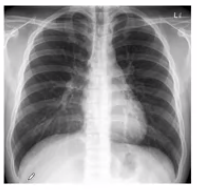

In [16]:
Image.open(img1)

If we flip the image

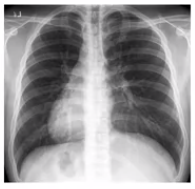

In [17]:
Image.open(img2)

We can now see the heart is middle left. If the classifier was looking to detect defects of the heart then this type of augmentation would not be suitable. 

#### Training

> Tip: `Garbage Collector` is a great way of freeing up memory if needed

In [56]:
#clear out some memory
import gc
gc.collect()

2770

Switching back to the full dataset

In [57]:
#switch back to the full dataset
items = get_dicom_files(pneumothorax_source, recurse=True, folders='train')
df = pd.read_csv(pneumothorax_source/f"labels.csv")

In [58]:
xtra_tfms = [RandomResizedCrop(194)]
batch_tfms = [*aug_transforms(do_flip=False, flip_vert=False, xtra_tfms=xtra_tfms), Normalize.from_stats(*imagenet_stats)]

In [59]:
set_seed(7)
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=Resize(256),
                   batch_tfms=batch_tfms)

dls = pneumothorax.dataloaders(df.values, bs=12, num_workers=0)

Check `train` and `valid` sizes

In [60]:
len(dls.train_ds), len(dls.valid_ds)

(200, 50)

In [64]:
net = xresnext50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
learn = Learner(dls, 
                net,
                metrics=[accuracy], 
                cbs=[ShowGraphCallback()])

> Tip: If you do not specifiy a loss function or optimization function `fastai` automatically allocates one.  You can view the `loss_func` and `opt_func` as follows:

In [65]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [66]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=0.001737800776027143)

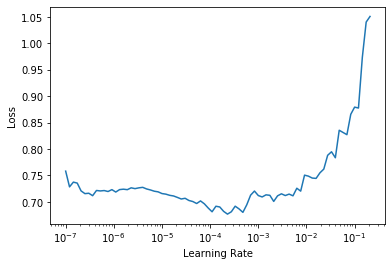

In [67]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.697180,0.693759,0.620000,00:24
1,0.718116,0.737178,0.720000,00:25
2,0.672629,0.627202,0.740000,00:24


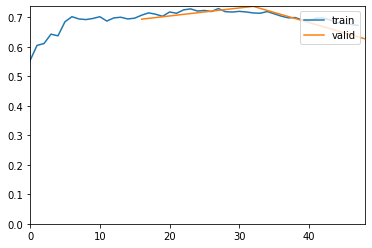

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3))

#### show_results

To see how `show_results` works, I slightly tweaked it so that we can see the ground truth, predictions and the probabilites.

> Tip: `get_preds` returns a tuple: Probabilites, Ground Truth, Prediction

In [72]:
def show_results2(self, ds_idx=1, dl=None, max_n=9, shuffle=False, **kwargs):
    if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    t,a,preds = self.get_preds(dl=[b], with_decoded=True)
    print(f'Ground Truth: {a}\n Probabilites: {t}\n Prediction: {preds}\n')
    self.dls.show_results(b, preds, max_n=max_n, **kwargs)

Ground Truth: TensorCategory([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], dtype=torch.int32)
 Probabilites: tensor([[0.4873, 0.5127],
        [0.4996, 0.5004],
        [0.4862, 0.5138],
        [0.4987, 0.5013],
        [0.4664, 0.5336],
        [0.4907, 0.5093],
        [0.5026, 0.4974],
        [0.4994, 0.5006],
        [0.5009, 0.4991],
        [0.5011, 0.4989],
        [0.4957, 0.5043],
        [0.4903, 0.5097]])
 Prediction: tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])



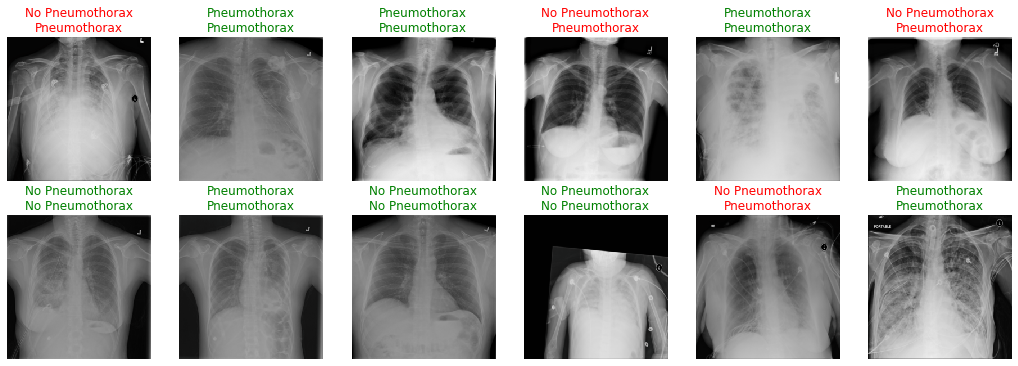

In [73]:
show_results2(learn, max_n=12, nrows=2, ncols=6)

The probabilies determine the predicted outcome.  In this dataset there are only 2 classes `No Pneumothorax` and `Pneumothorax` hence the reason why each probability has 2 values, the first value is the probability whether the image belongs to class 0 or `No Pneumothorax` and the second value is the probability whether the image belongs to class 1 or `Pneumothorax`

> Tip: What we can see in this case is that the probabilities are very close to each other around the 0.4-0.6 range, meaning that the model is really not very good at making predictions.  We need to get results where the probabilities are more `certain` in their predictions. For example: [0.4903, 0.5097] and [0.1903, 0.8097] both produce the same results that the image belongs to class 1 but in the second case the model is alot more `certain` that it belongs to class 1.

### Model Evaluation

Because medical models are high impact it is important to know how good a model is at detecting a certain condition.

#### Accuracy

The above model has an `accuracy` of 74%.  One needs to look deeper into how the accuracy of 74% was calculated and whether it is acceptable.

- `Accuracy` is the probablity that the model is correct or 


- `Accuracy` is the probability that the model is correct and the patient has the condition PLUS the probability that the model is correct and the patient does not have the condition 

#### False Positive & False Negative

There are some other key terms that need to be used when evaluating medical models:

- `False Negative` is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present.


- `False Positive` is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present

#### Sensitivity & Specificity

- `Sensitivity` or `True Positive Rate` is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives

**Example:** A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition


- `Specificity` or `True Negative Rate` is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives

> Tip: [Understanding and using sensitivity, specificity and predictive values](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a great paper if you are interested in learning more

#### PPV and NPV

Most medical testing is evaluated via `PPV` (Postive Predictive Value) or `NPV` (Negative Predictive Value).

- `PPV` - if the model predicts a patient has a condition what is probabilty that the patient actually has the condition

- `NPV` - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

#### Confusion Matrix

Plot a confusion matrix - note that this is plotted against the `valid` dataset size which is 75 in this case

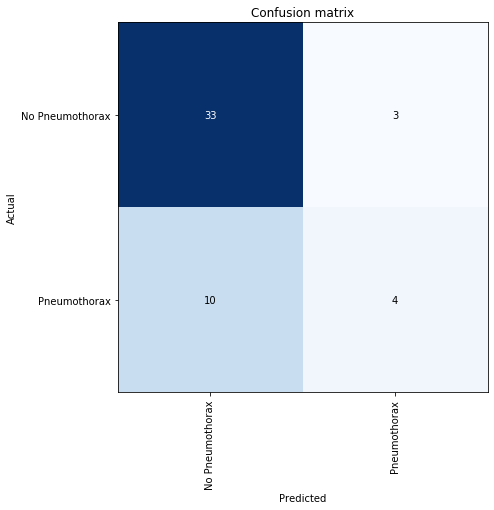

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [38]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

33 3 10 4


**Sensitivity** = True Positive/(True Positive + False Negative)

In [39]:
sensitivity = tp/(tp + fn)
sensitivity

0.2857142857142857

In this case the model only has a sensitivity of 28% and hence is only capable of correctly detecting 28% True Positives(ie who have Pneumothorax) but will miss 72% of False Negatives (patients that actually have Pneumothorax but were told they did not! Not a good situation to be in).  

This is also know as a **Type II error**

**Specificity** = True Negative/(False Positive + True Negative)

In [46]:
specificity = tn/(fp + tn)
specificity

0.9166666666666666

In this case the model has a specificity of 91% and hence can correctly detect 91% of the time that a patient does not have Pneumothorax but will incorrectly classify that 9% of the patients have Pneumothorax (False Postive) but actually do not.

This is also known as a **Type I error**

**Positive Predictive Value (PPV)**

In [47]:
ppv = tp/(tp+fp)
ppv

0.5714285714285714

In this case the model performs poorly in correctly predicting patients with Pneumothorax

**Negative Predictive Value (NPV)**

In [48]:
npv = tn/(tn+fn)
npv

0.7674418604651163

This model is better at predicting patients with No Pneumothorax

Some of these metrics can be calculated using `sklearn`'s classification report

In [49]:
interp.print_classification_report()

                 precision    recall  f1-score   support

No Pneumothorax       0.77      0.92      0.84        36
   Pneumothorax       0.57      0.29      0.38        14

       accuracy                           0.74        50
      macro avg       0.67      0.60      0.61        50
   weighted avg       0.71      0.74      0.71        50



### Calculating Accuracy

The accuracy of this model as mentioned before is 74% - lets now calculate this!

We can also look at `Accuracy` as:

**accuracy = sensitivity x prevalence + specificity * (1 - prevalence)**

`Prevalence` is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time.  

The prevalence in this case is how many patients in the `valid` dataset have the condition compared to the total number. To view the number of `Pneuomothorax` patients in the `valid` set

In [44]:
t= dls.valid_ds.cat
#t[0]

There are 20 `Pneumothorax` images in the valid set hence the prevalance here is 20/75 = 0.27

In [50]:
accuracy = (0.28 * 0.27) + (0.91 * (1 - 0.27))
accuracy

0.7399

By reviewing the metrics above, you can evaluate how good or bad your model is performing

### fin